Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 


Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [ ]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/datasets/autos.csv')
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
print(df.shape)
print(df.info())

(354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


In [ ]:
# Проверим датасет на дубликаты
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [ ]:
# Удалим дубликаты
df = df.drop_duplicates().reset_index(drop = True)

Проверим датасет на пропуски.

In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Заполним пропущенные значения

In [ ]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [ ]:
print(df.groupby('FuelType')['FuelType'].count())
print()
print('Количство пропущеных значений в столбце FuelType =', df.query('FuelType.isnull() == True').shape[0])

# Так как пропущенных значений примерно 10% от всего датасета, удалять их не стоит. Заполним пропуски значением "gasoline" 
# так как "gasoline" и "petrol" самые распространенные значения, но обозначпают они одно и тоже.

df['FuelType'] = df['FuelType'].fillna('gasoline')

print(df.groupby('FuelType')['FuelType'].count())

FuelType
cng            565
electric        90
gasoline     98719
hybrid         233
lpg           5310
other          204
petrol      216349
Name: FuelType, dtype: int64

Количство пропущеных значений в столбце FuelType = 32895
FuelType
cng            565
electric        90
gasoline    131614
hybrid         233
lpg           5310
other          204
petrol      216349
Name: FuelType, dtype: int64


Заполним пропуски в столбце NotRepaired. Скорее всего, пропущенные значений означают, что автомобиль не был в ремонте. Заполним из значением "no"

In [ ]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [ ]:
print(df.groupby('Gearbox')['Gearbox'].count())

# Так как мы не можем востановить тип коробки передач в столбце "Gearbox", заполним пропуски значением "other"

df['Gearbox'] = df['Gearbox'].fillna('other')

print()
print(df.groupby('Gearbox')['Gearbox'].count())

Gearbox
auto       66283
manual    268249
Name: Gearbox, dtype: int64

Gearbox
auto       66283
manual    268249
other      19833
Name: Gearbox, dtype: int64


In [ ]:
# Таким же образом заполним пропуске в столбеце "Model"
df['Model'] = df['Model'].fillna('other')

In [ ]:
#заполним пропуски в столбце "VehicleType" максимально частым значениям с группировкой по марке и модели
df['VehicleType'] = df['VehicleType'].transform(lambda x: x.fillna(x.mode()[0]))

df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Столбцы "DateCrawled", "DateCreated", "LastSeen", и "PostalCode" не имеюит особого влияния на датасет. Например корреляция между ценой "Price" и индексом "PostalCode" совсем незначительная.
Удалим эти столбцы из нашего датасета.

In [ ]:
df['PostalCode'].corr(df['Price'])

0.07605843354490023

In [ ]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis='columns')
print(df.shape)
print(df.info())

(354365, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 12 columns):
Price                354365 non-null int64
VehicleType          354365 non-null object
RegistrationYear     354365 non-null int64
Gearbox              354365 non-null object
Power                354365 non-null int64
Model                354365 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             354365 non-null object
Brand                354365 non-null object
NotRepaired          354365 non-null object
NumberOfPictures     354365 non-null int64
dtypes: int64(6), object(6)
memory usage: 32.4+ MB
None


In [ ]:
print(df.shape)
print(df.info())

(354365, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 12 columns):
Price                354365 non-null int64
VehicleType          354365 non-null object
RegistrationYear     354365 non-null int64
Gearbox              354365 non-null object
Power                354365 non-null int64
Model                354365 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             354365 non-null object
Brand                354365 non-null object
NotRepaired          354365 non-null object
NumberOfPictures     354365 non-null int64
dtypes: int64(6), object(6)
memory usage: 32.4+ MB
None


**Рассмотрим на выбросы значений и характеристики признаков**

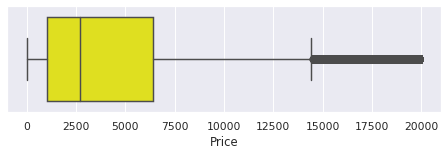

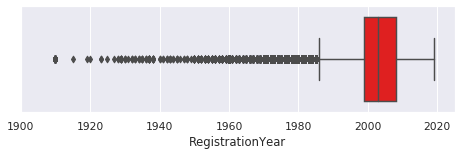

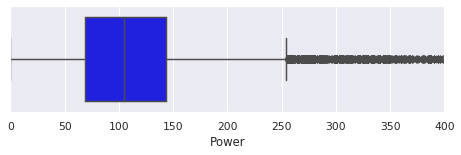

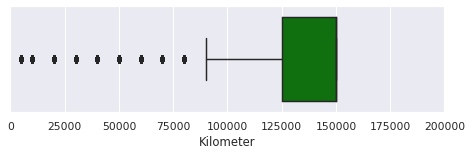

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [ ]:
sns.set()
plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(df['Price'], color="yellow")
plt.show()

plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(df['RegistrationYear'], color="red")
plt.xlim(1900, 2025)
plt.show()

plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(df['Power'], color="blue")
plt.xlim(0, 400)
plt.show()

plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(df['Kilometer'], color="green")
plt.xlim(0, 200000)
plt.show()

df[['Price', 'RegistrationYear', 'Power', 'Kilometer']].describe()

Как видно из графиков, призаки имеют большие выбросы значений. Удалим выбросы из датасета.

In [ ]:
df_clear = (df.query('(Price < 15000) & (Price > 100) & (RegistrationYear > 1980) & (RegistrationYear < 2020) & (Power < 400) & (Power > 50)')
              .reset_index(drop= True)
           )


# 2. Обучение моделей

Разобьем датасет на тренировочную, валидационную и тестовую выборки.

In [ ]:
# Создадим список категориальных признаков
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

df_clear[cat_columns] = df_clear[cat_columns].astype('category')

features = df_clear.drop(['Price'], axis='columns')
target = df_clear['Price']
    
features_train, features_valid, target_train, target_valid = (train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.3, 
                                                                              random_state=42)
                                                                            )
    
features_valid, features_test, target_valid, target_test = (train_test_split(features_valid, 
                                                                              target_valid, 
                                                                              test_size=0.5, 
                                                                              random_state=42)
                                                                           )

Обучим модель градиентного бустинга CatBoost.

In [ ]:
%%time

catboost_model = CatBoostRegressor(eval_metric="RMSE", 
                                   iterations=100, 
                                   max_depth=12, 
                                   learning_rate=0.3, 
                                   leaf_estimation_method='Gradient', 
                                   random_state=42)

catboost_model.fit(features_train, target_train, cat_features=cat_columns, verbose=10)
prediction = catboost_model.predict(features_valid)
rmse = mean_squared_error(target_valid, prediction)**0.5
rmse 

0:	learn: 2938.3795421	total: 753ms	remaining: 1m 14s
10:	learn: 1497.8675550	total: 6.85s	remaining: 55.4s
20:	learn: 1413.8277802	total: 12.7s	remaining: 48s
30:	learn: 1365.6027648	total: 18.7s	remaining: 41.7s
40:	learn: 1331.5724347	total: 24.6s	remaining: 35.5s
50:	learn: 1302.3771294	total: 30.5s	remaining: 29.3s
60:	learn: 1279.7474180	total: 36.4s	remaining: 23.3s
70:	learn: 1261.0691957	total: 42.2s	remaining: 17.2s
80:	learn: 1245.1007435	total: 48.1s	remaining: 11.3s
90:	learn: 1232.6406246	total: 54.1s	remaining: 5.35s
99:	learn: 1218.9413142	total: 59.3s	remaining: 0us
CPU times: user 52 s, sys: 7.99 s, total: 1min
Wall time: 1min 3s


1340.7276318568806

Теперь обучим модель LGBM Regressor.

In [ ]:
%%time

lgbm_model = LGBMRegressor(num_leaves=40, learning_rate=0.35, n_estimators=100)
lgbm_model.fit(features_train, target_train, categorical_feature=cat_columns)
prediction = lgbm_model.predict(features_valid)
rmse = mean_squared_error(target_valid, prediction)**0.5
rmse 

CPU times: user 6.2 s, sys: 47.6 ms, total: 6.24 s
Wall time: 6.26 s


1340.9208807012585

# 3. Анализ моделей

Протестируем модели на тестовой выборке.

In [ ]:
%%time
prediction = catboost_model.predict(features_test)
rmse = mean_squared_error(target_test, prediction)**0.5
rmse 

CPU times: user 110 ms, sys: 8.83 ms, total: 118 ms
Wall time: 52.9 ms


1347.9447811951284

In [ ]:
%%time
prediction = lgbm_model.predict(features_test)
rmse = mean_squared_error(target_test, prediction)**0.5
rmse 

CPU times: user 407 ms, sys: 0 ns, total: 407 ms
Wall time: 334 ms


1344.384273386913

### Вывод.

Как мы видим, обе модели показали примерно одинаковые результаты как по скорости, так и по предсказанию. Но есть небольшие различия: CatBoost работает немного быстрее, но у LGBM Regressor немного выше точность предсказания.